In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=30,15

In [5]:
dataset = pd.read_csv('test.csv')
dataset = dataset.loc[:, ['Date', 'PDSI']]
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.set_index(['Date'])

In [6]:
dataset.head()

,PDSI
Date,
1975-01-01,2.932236
1975-02-01,3.385542
1975-03-01,4.066188
1975-04-01,3.933788
1975-05-01,4.066256


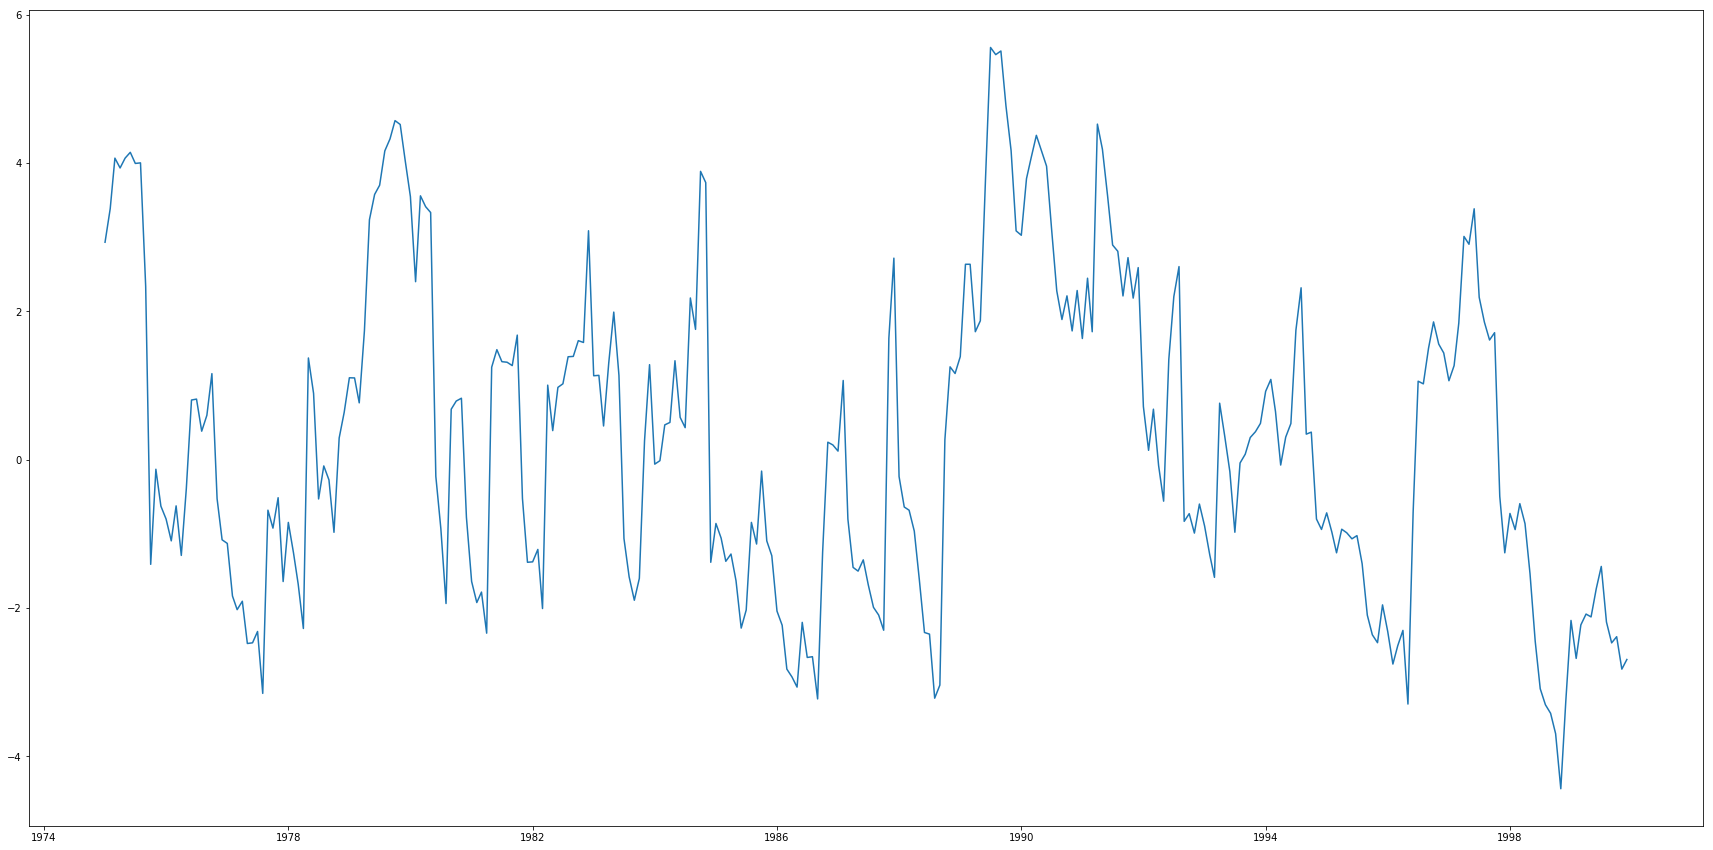

In [7]:
plt.plot(dataset)

In [20]:
#determining rolling statistics
rollmean = dataset.rolling(window=12).mean()
rollstd = dataset.rolling(window=12).std()
print(rollmean,rollstd)

                PDSI
Date                
1975-01-01       NaN
1975-02-01       NaN
1975-03-01       NaN
1975-04-01       NaN
1975-05-01       NaN
1975-06-01       NaN
1975-07-01       NaN
1975-08-01       NaN
1975-09-01       NaN
1975-10-01       NaN
1975-11-01       NaN
1975-12-01  2.558138
1976-01-01  2.247192
1976-02-01  1.873909
1976-03-01  1.483219
1976-04-01  1.047905
1976-05-01  0.676420
1976-06-01  0.398124
1976-07-01  0.133360
1976-08-01 -0.168106
1976-09-01 -0.312898
1976-10-01 -0.098641
1976-11-01 -0.131744
1976-12-01 -0.169524
1977-01-01 -0.196962
1977-02-01 -0.258925
1977-03-01 -0.375520
1977-04-01 -0.427016
1977-05-01 -0.600841
1977-06-01 -0.873637
...              ...
1997-07-01  1.920628
1997-08-01  1.990041
1997-09-01  1.999338
1997-10-01  1.987244
1997-11-01  1.816242
1997-12-01  1.591699
1998-01-01  1.442586
1998-02-01  1.258350
1998-03-01  1.055441
1998-04-01  0.732719
1998-05-01  0.362366
1998-06-01 -0.123605
1998-07-01 -0.563402
1998-08-01 -0.993348
1998-09-01 -1

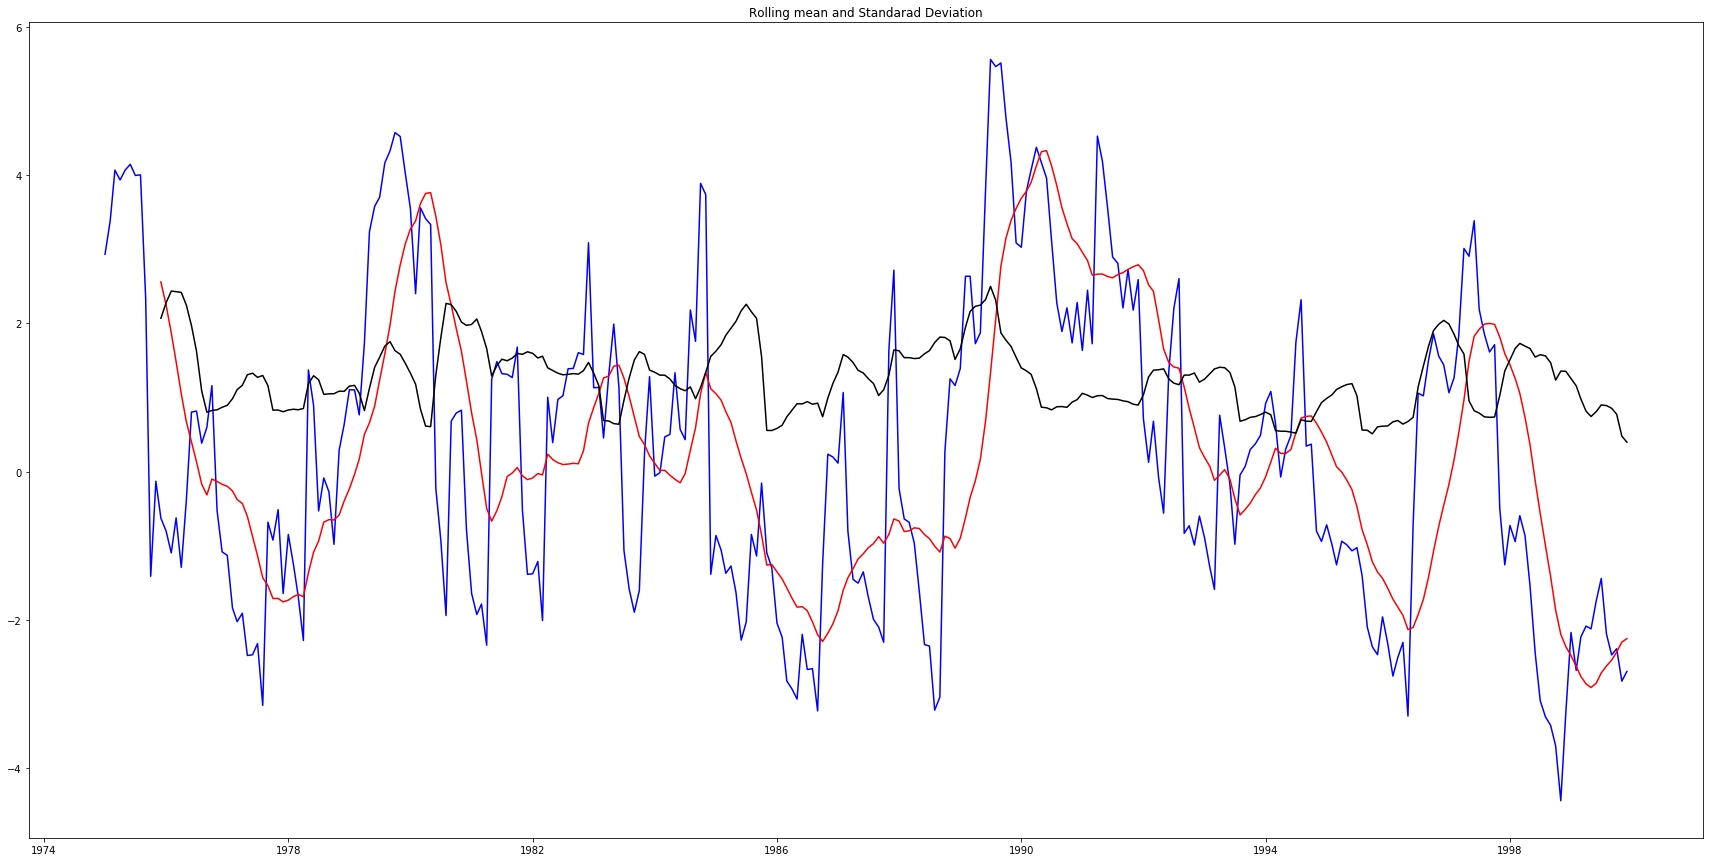

In [21]:
orig=plt.plot(dataset,color='blue')
mean=plt.plot(rollmean,color='red')
dev=plt.plot(rollstd,color='black')
plt.title('Rolling mean and Standarad Deviation')
plt.show()

In [22]:
def test_stationarity(timeseries):
    movingaverage=timeseries.rolling(window=12).mean()
    movingstd=timeseries.rolling(window=12).std()
    orig=plt.plot(timeseries,color='blue')
    mean=plt.plot(movingaverage,color='red')
    dev=plt.plot(movingstd,color='black')
    plt.title('Rolling mean and Standarad Deviation')
    plt.show()

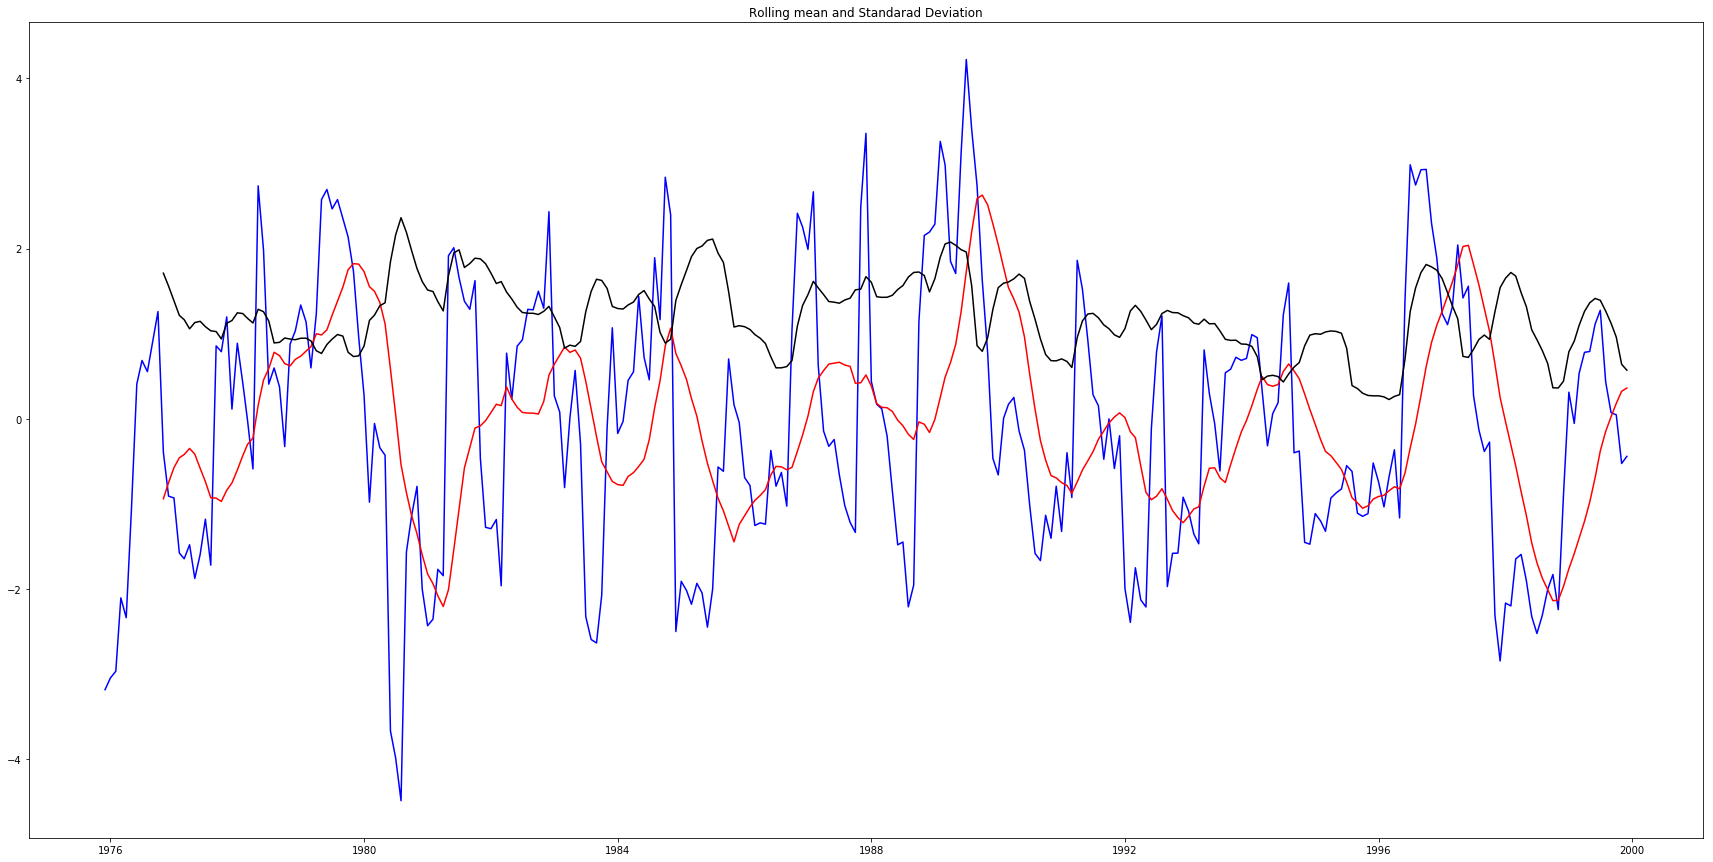

In [23]:
minusmovingaverage=dataset-rollmean
minusmovingaverage.dropna(inplace=True)
test_stationarity(minusmovingaverage)

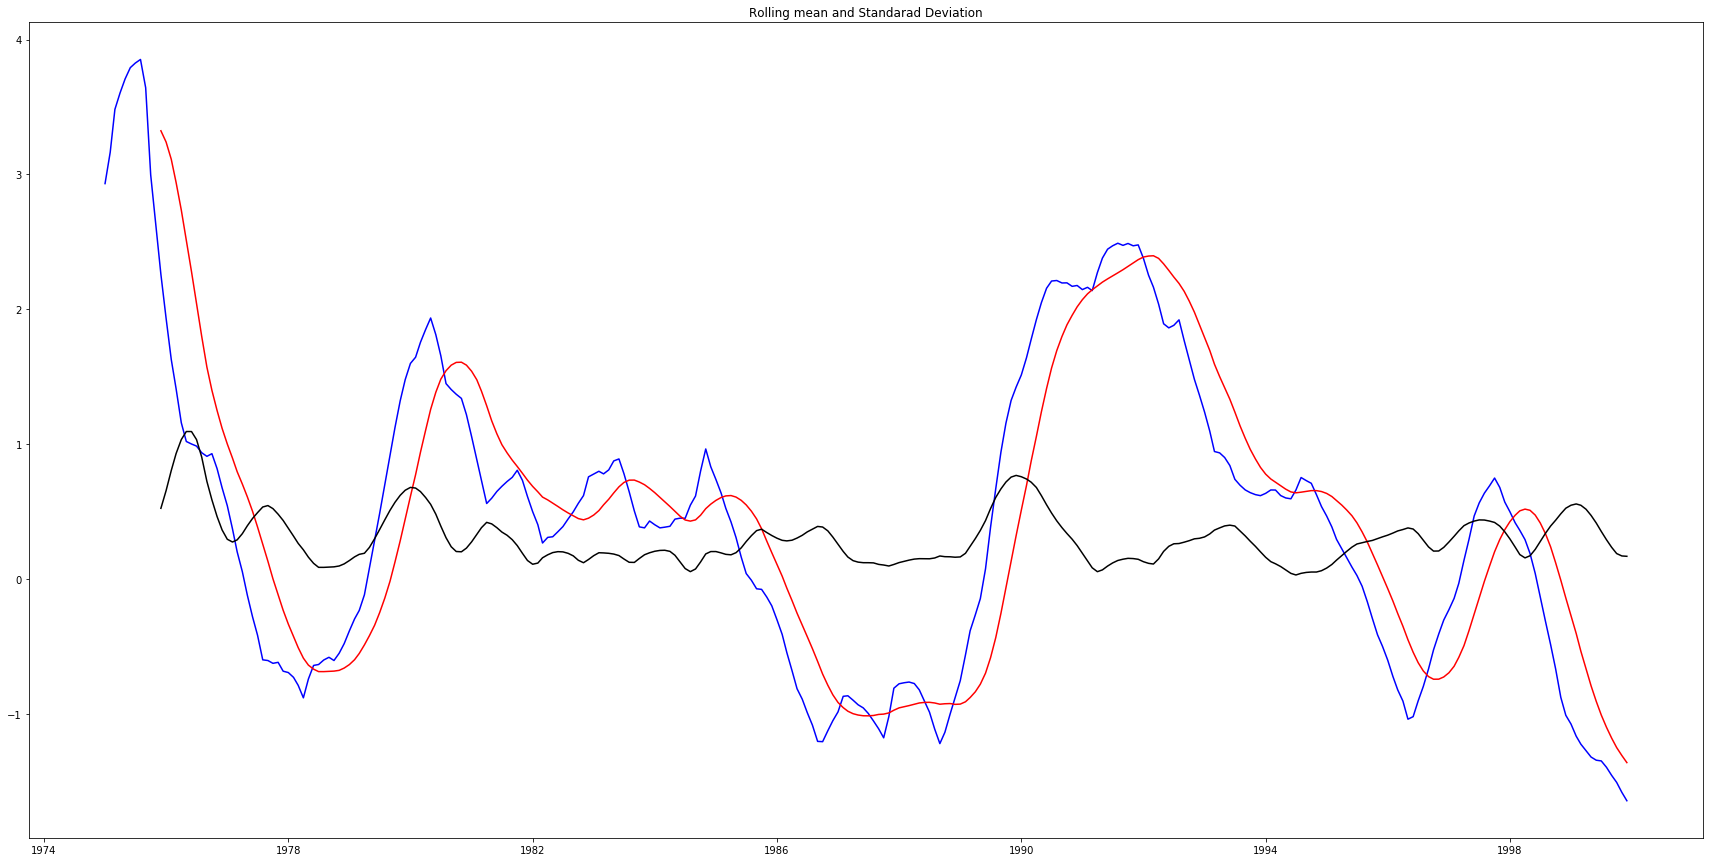

In [24]:
exponentialDecayWeightedAverage=dataset.ewm(halflife=12,min_periods=0,adjust=True).mean()
test_stationarity(exponentialDecayWeightedAverage)

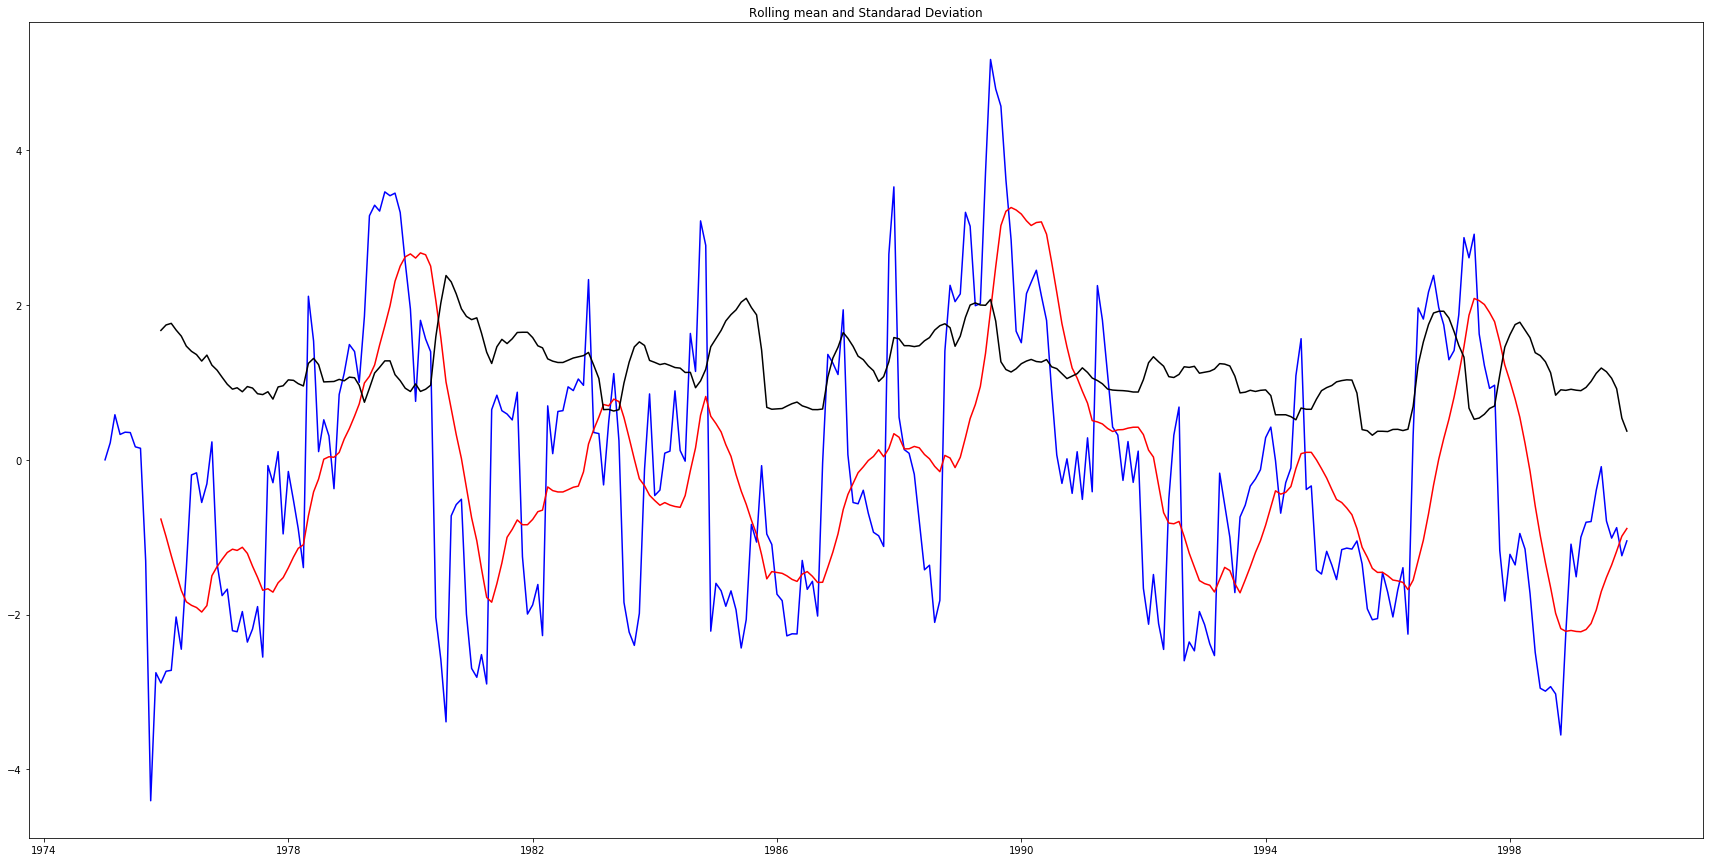

In [25]:
datasetdifference=dataset-exponentialDecayWeightedAverage
test_stationarity(datasetdifference)

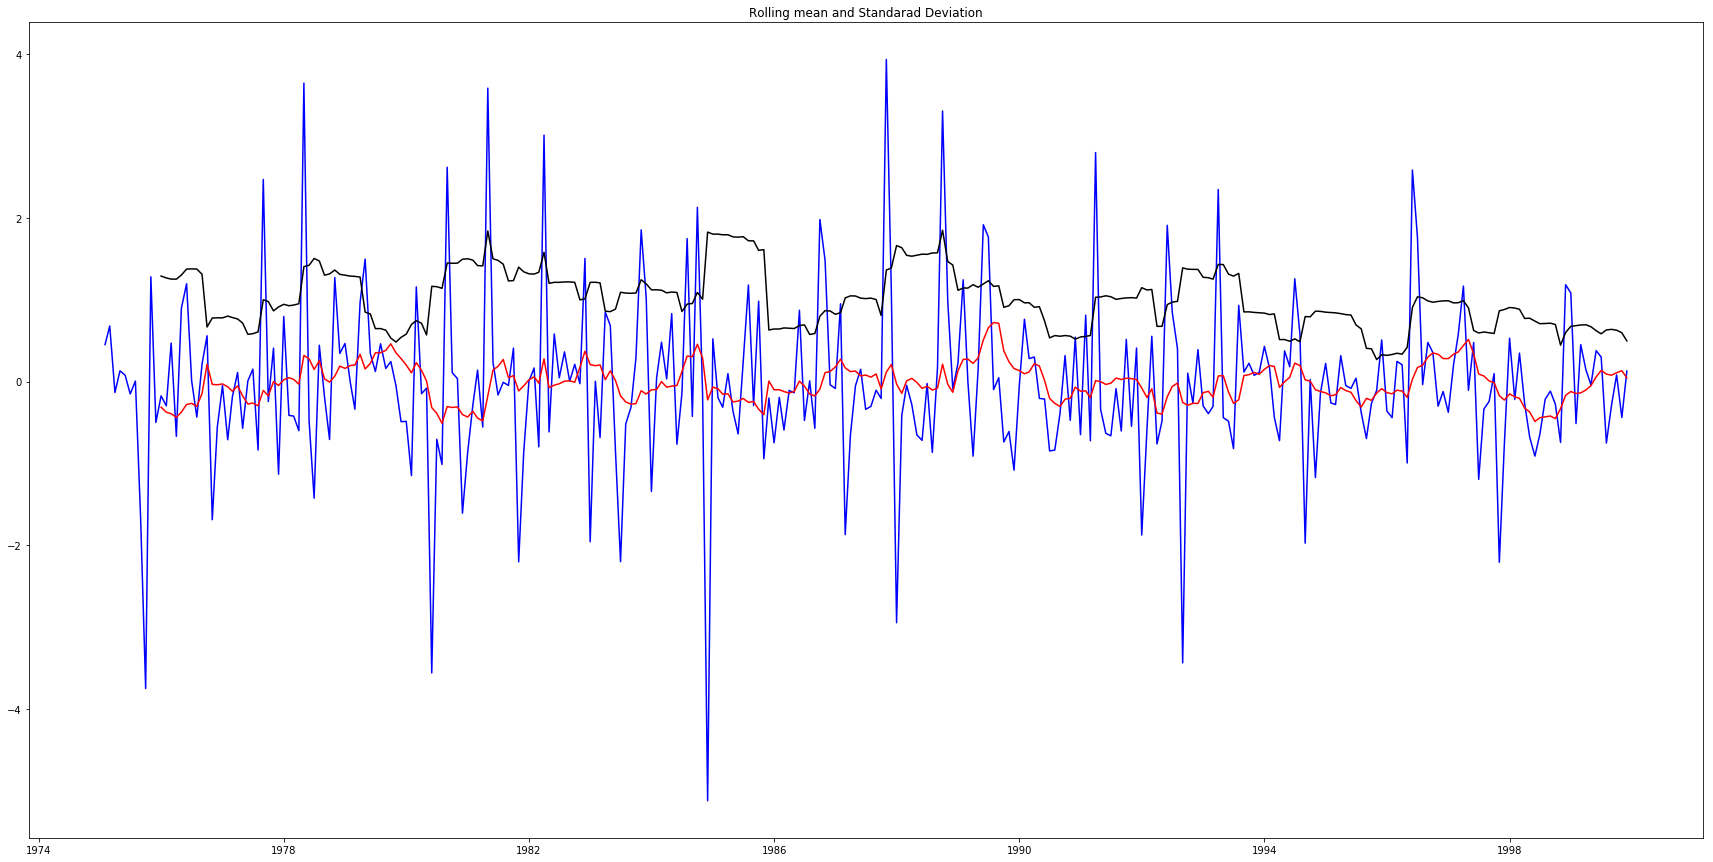

In [26]:
dataset_shift=dataset-dataset.shift()
dataset_shift.dropna(inplace=True)
test_stationarity(dataset_shift)

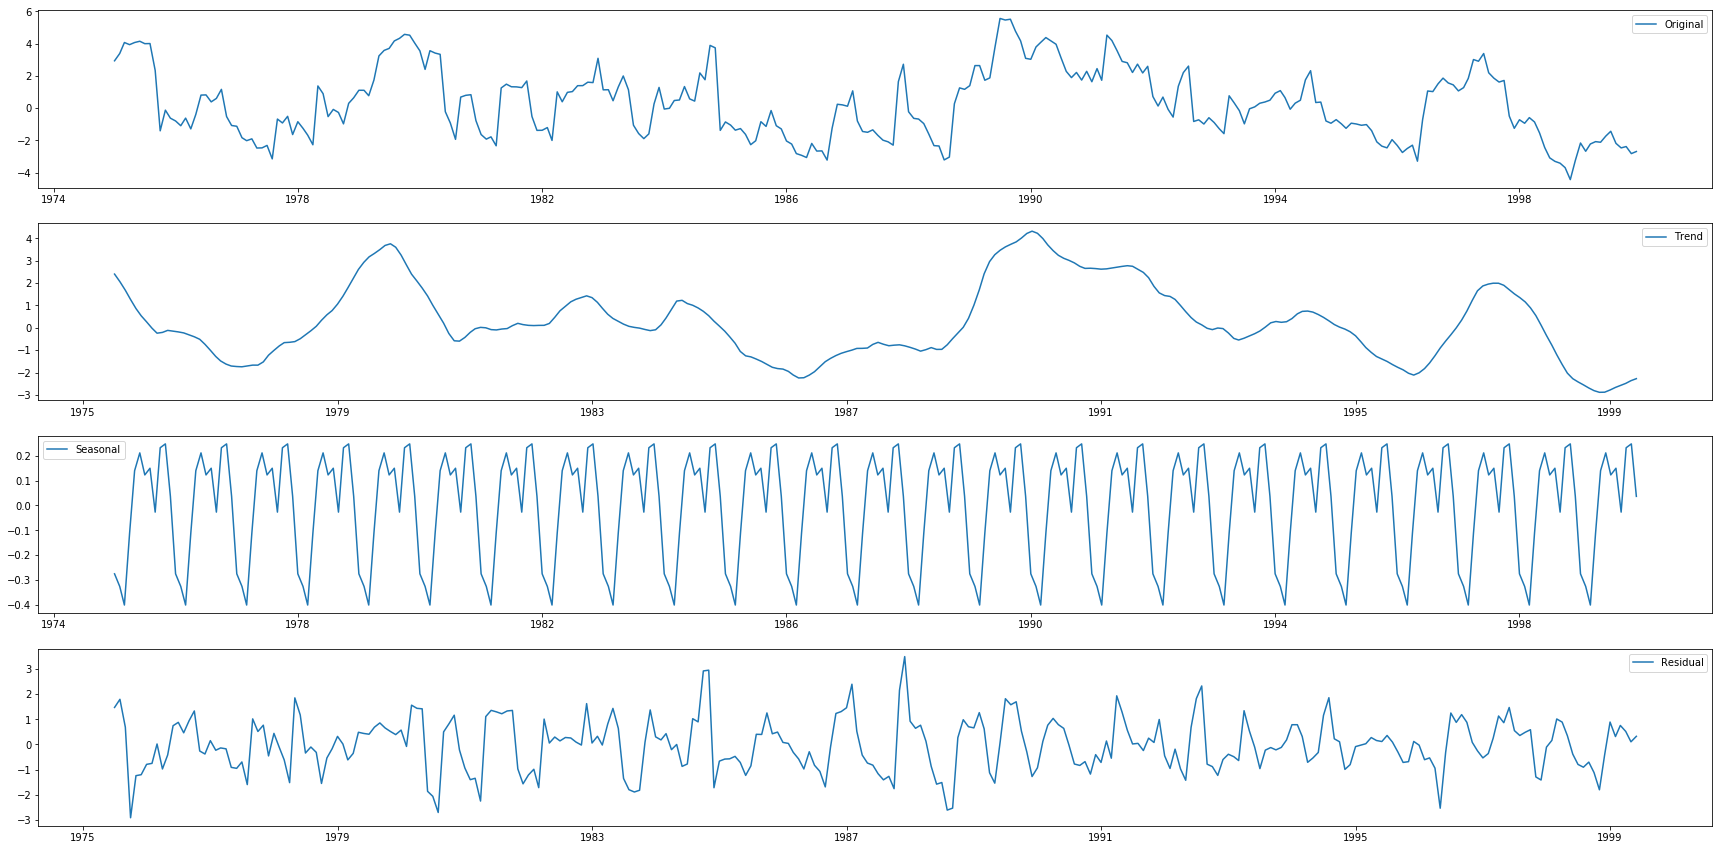

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset.PDSI)
trend=decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dataset,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.show()


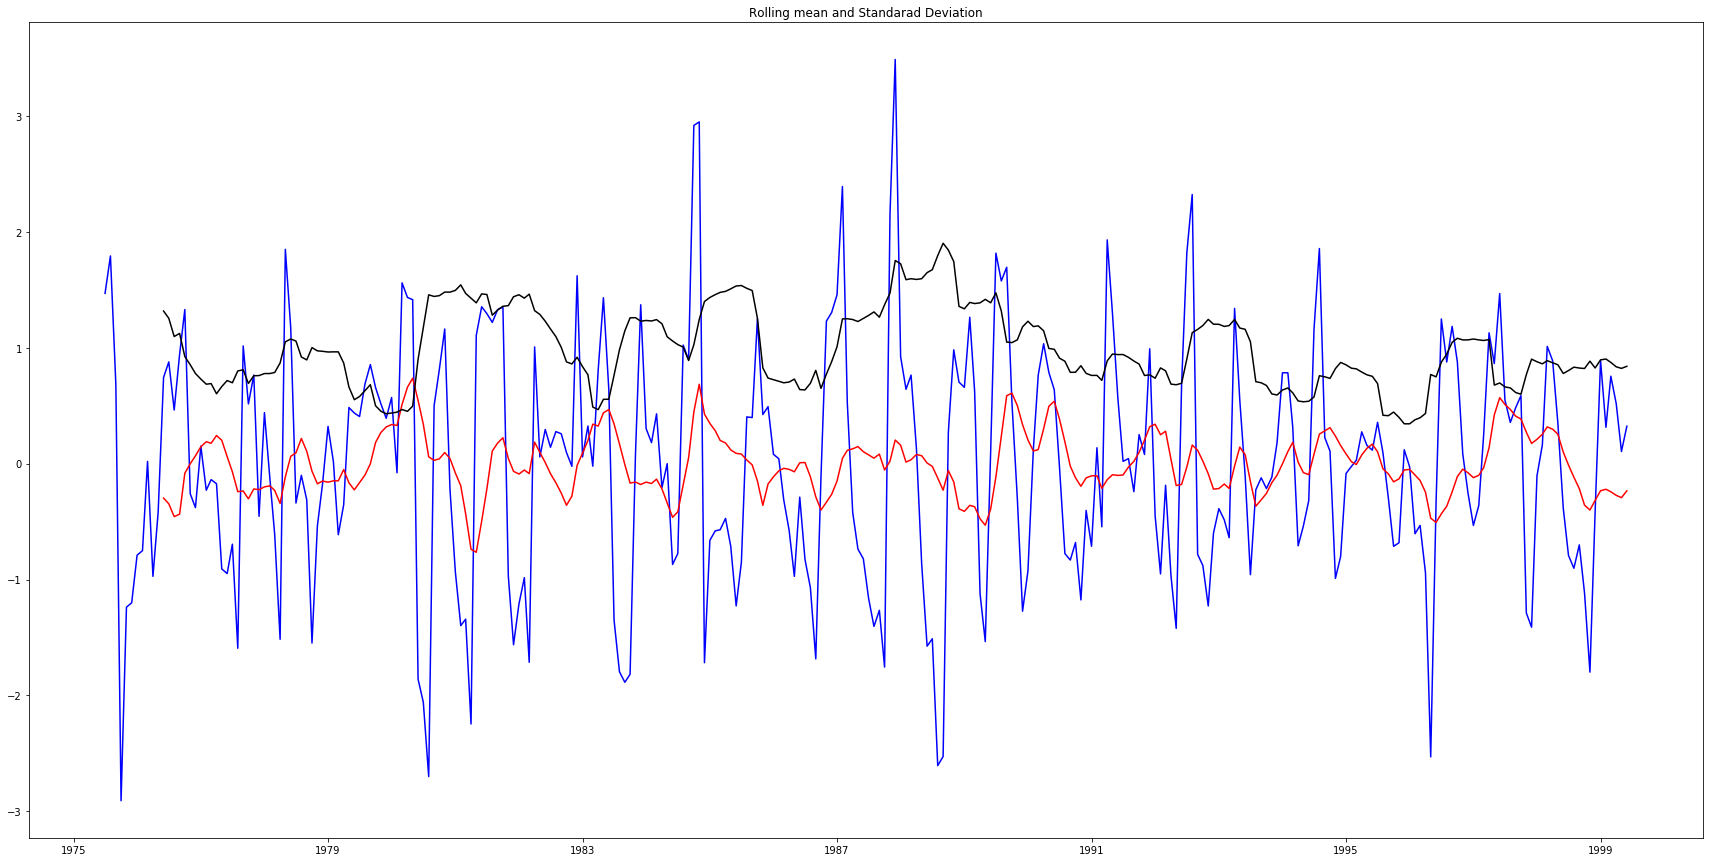

In [28]:
decomposed_data=residual
decomposed_data.dropna(inplace=True)
test_stationarity(decomposed_data)

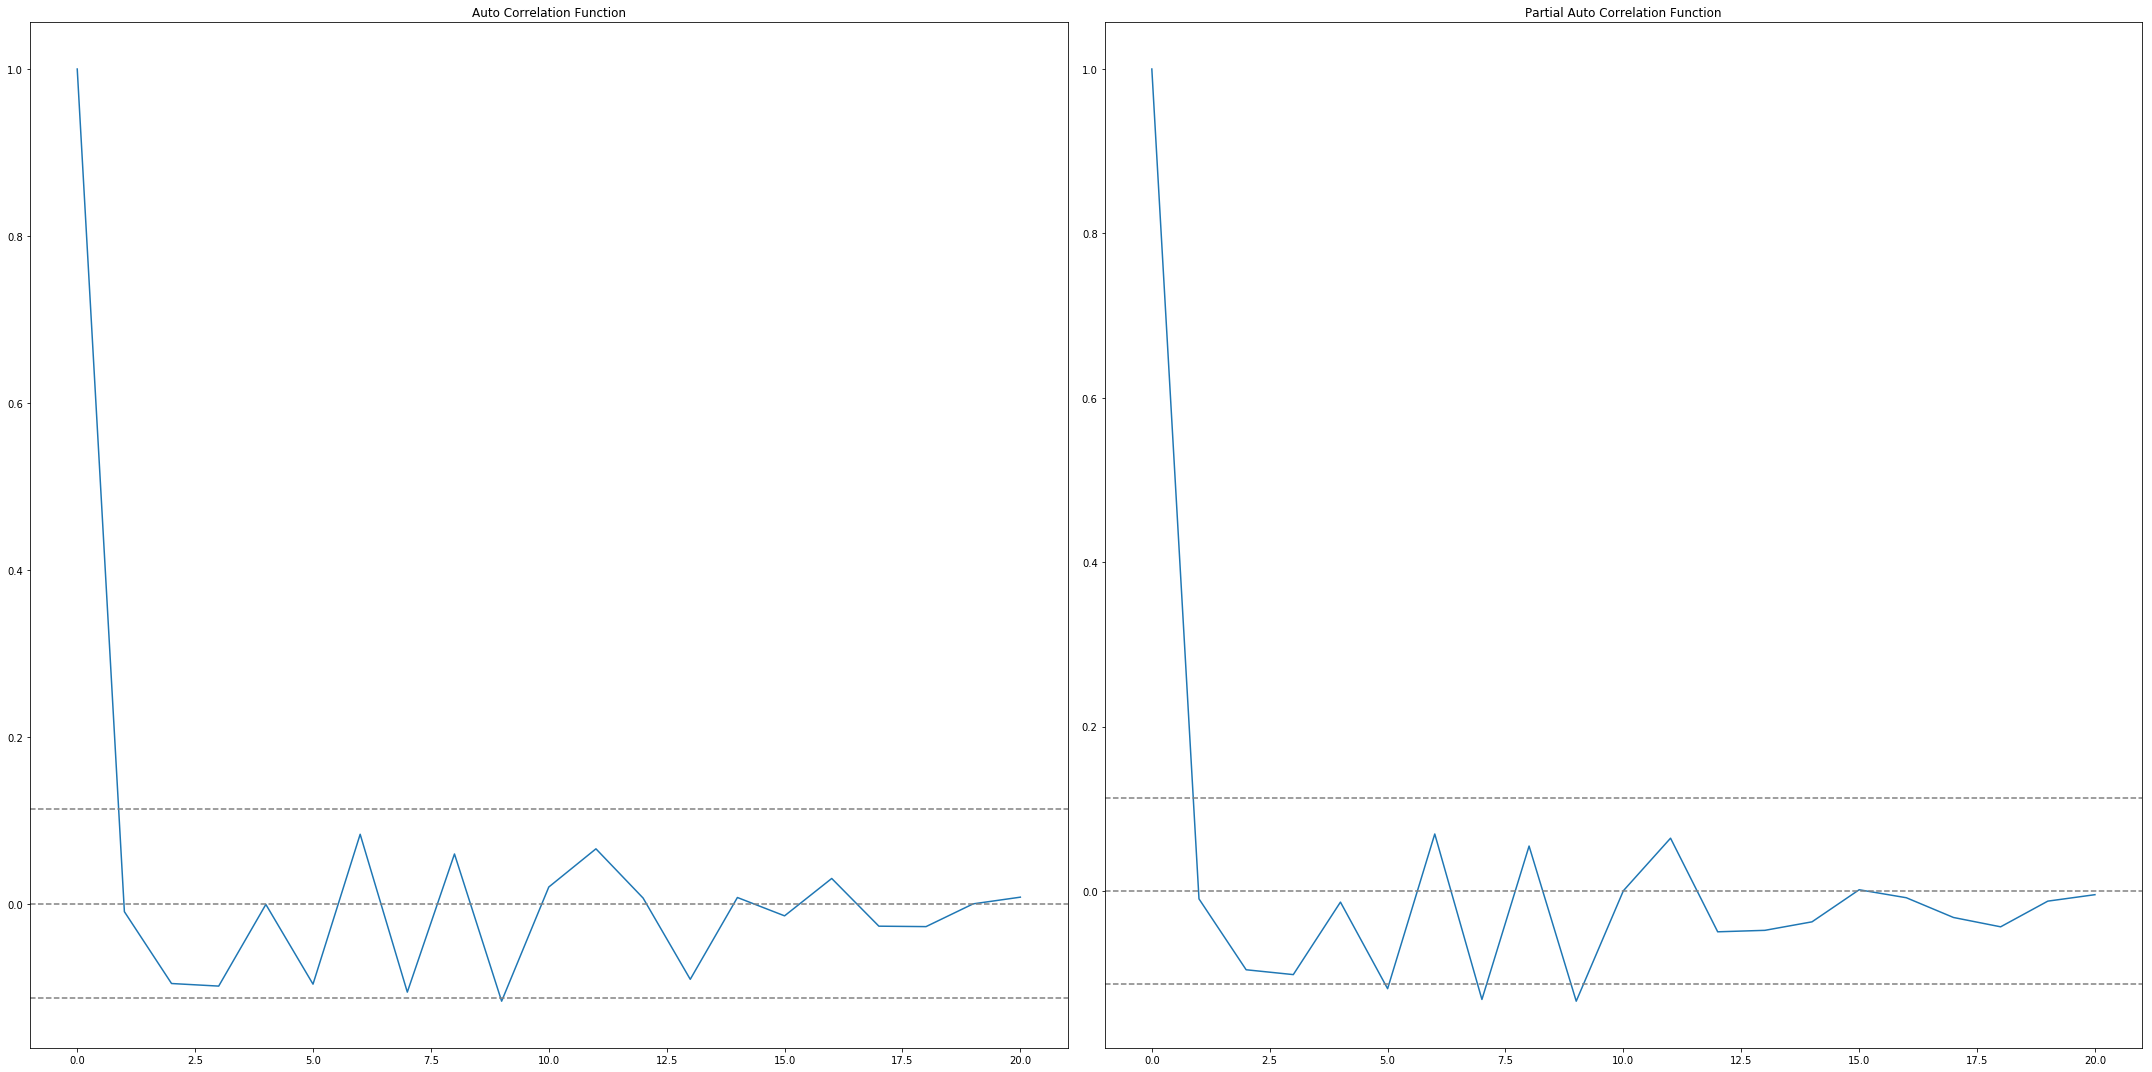

In [29]:
#ACF and PACF plots
from statsmodels.tsa.stattools import acf,pacf

log_acf= acf(dataset_shift,nlags=20)
log_pacf = pacf(dataset_shift,nlags=20,method='ols')

#plot ACF
plt.subplot(121)
plt.plot(log_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_shift)),linestyle='--',color='gray')
plt.title('Auto Correlation Function')

#plot PACF
plt.subplot(122)
plt.plot(log_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_shift)),linestyle='--',color='gray')
plt.title('Partial Auto Correlation Function')
plt.tight_layout()

C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Plotting ARIMA model


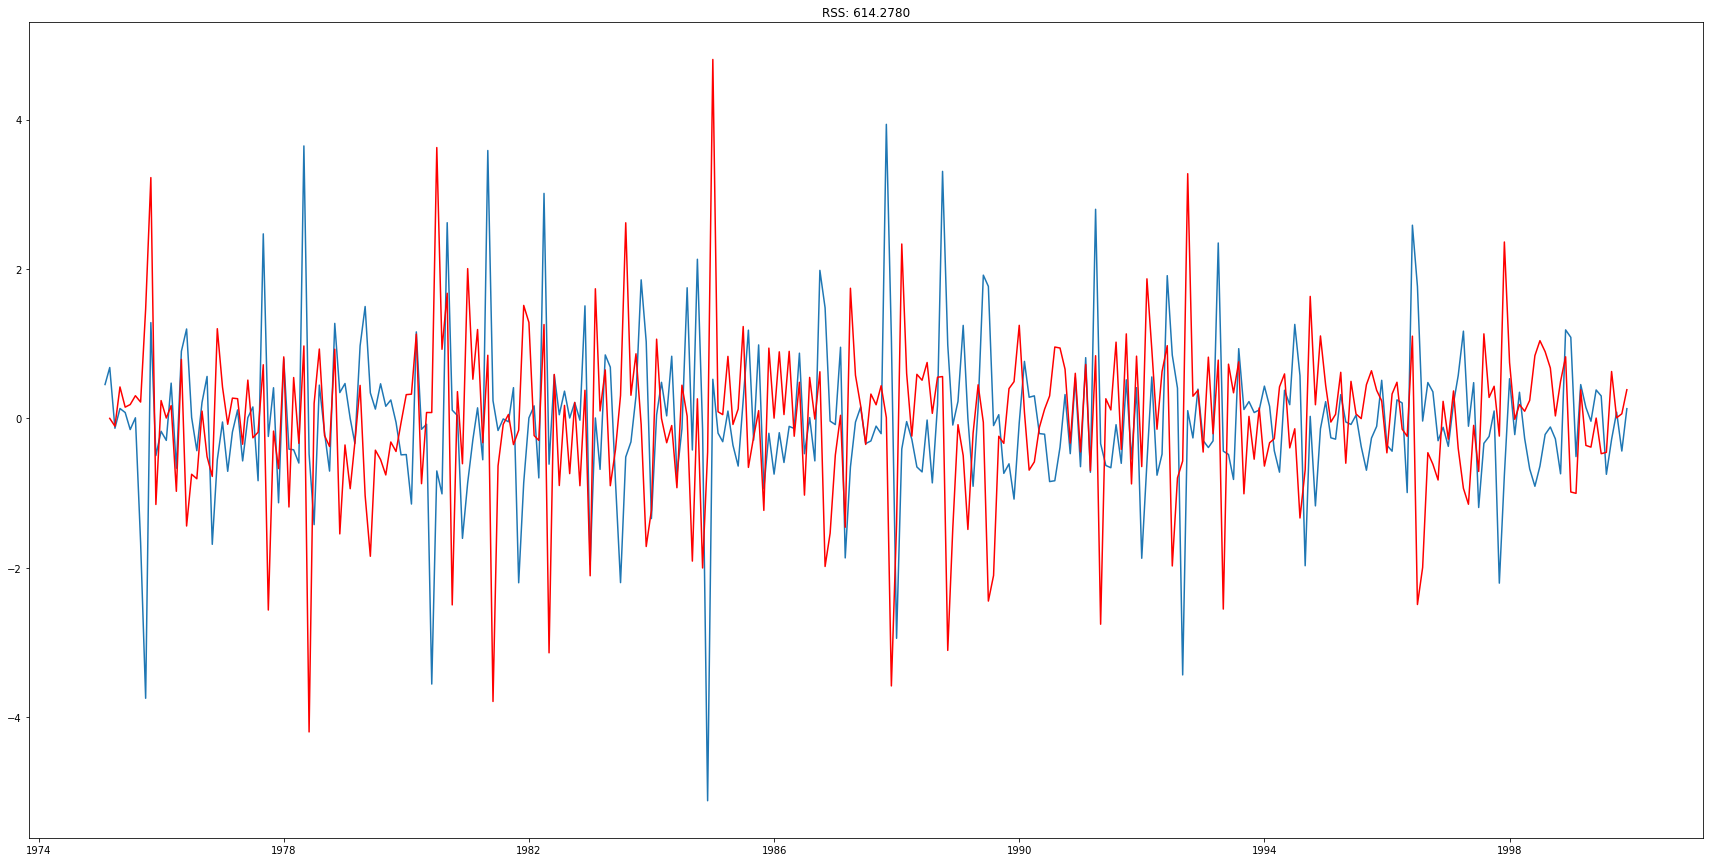

In [30]:
from statsmodels.tsa.arima_model import ARIMA

#AR Model
model = ARIMA(dataset_shift,order=(2,1,1e))
results_ARIMA=model.fit(disp=-1)
plt.plot(dataset_shift)
plt.plot(results_ARIMA.fittedvalues,color='red')
rss=results_ARIMA.fittedvalues-dataset_shift['PDSI']
rss.dropna(inplace=True)
plt.title('RSS: %.4f'% sum((rss)**2))
print('Plotting ARIMA model')

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
print(predictions_ARIMA_diff.head())

Date
1975-03-01   -0.000013
1975-04-01   -0.104656
1975-05-01    0.420509
1975-06-01    0.150227
1975-07-01    0.185017
dtype: float64


In [32]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Date
1975-03-01   -0.000013
1975-04-01   -0.104669
1975-05-01    0.315840
1975-06-01    0.466067
1975-07-01    0.651084
dtype: float64


C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


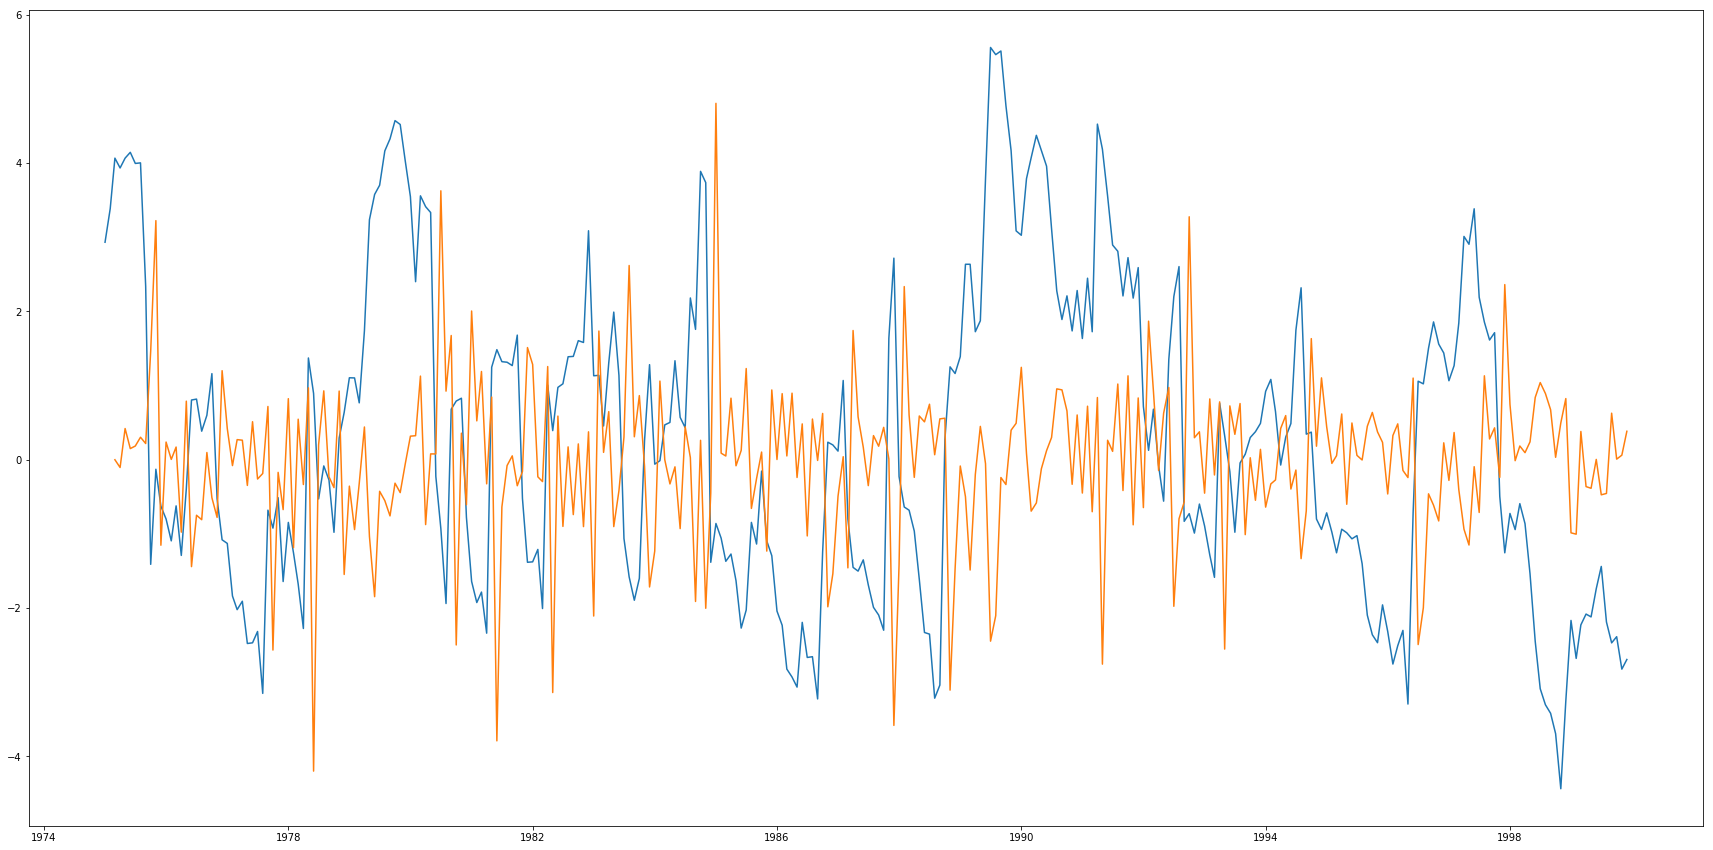

In [33]:
predictions_ARIMA = pd.Series(dataset['PDSI'].ix[0], index=dataset.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA.head()
plt.plot(dataset)
plt.plot(predictions_ARIMA_diff)


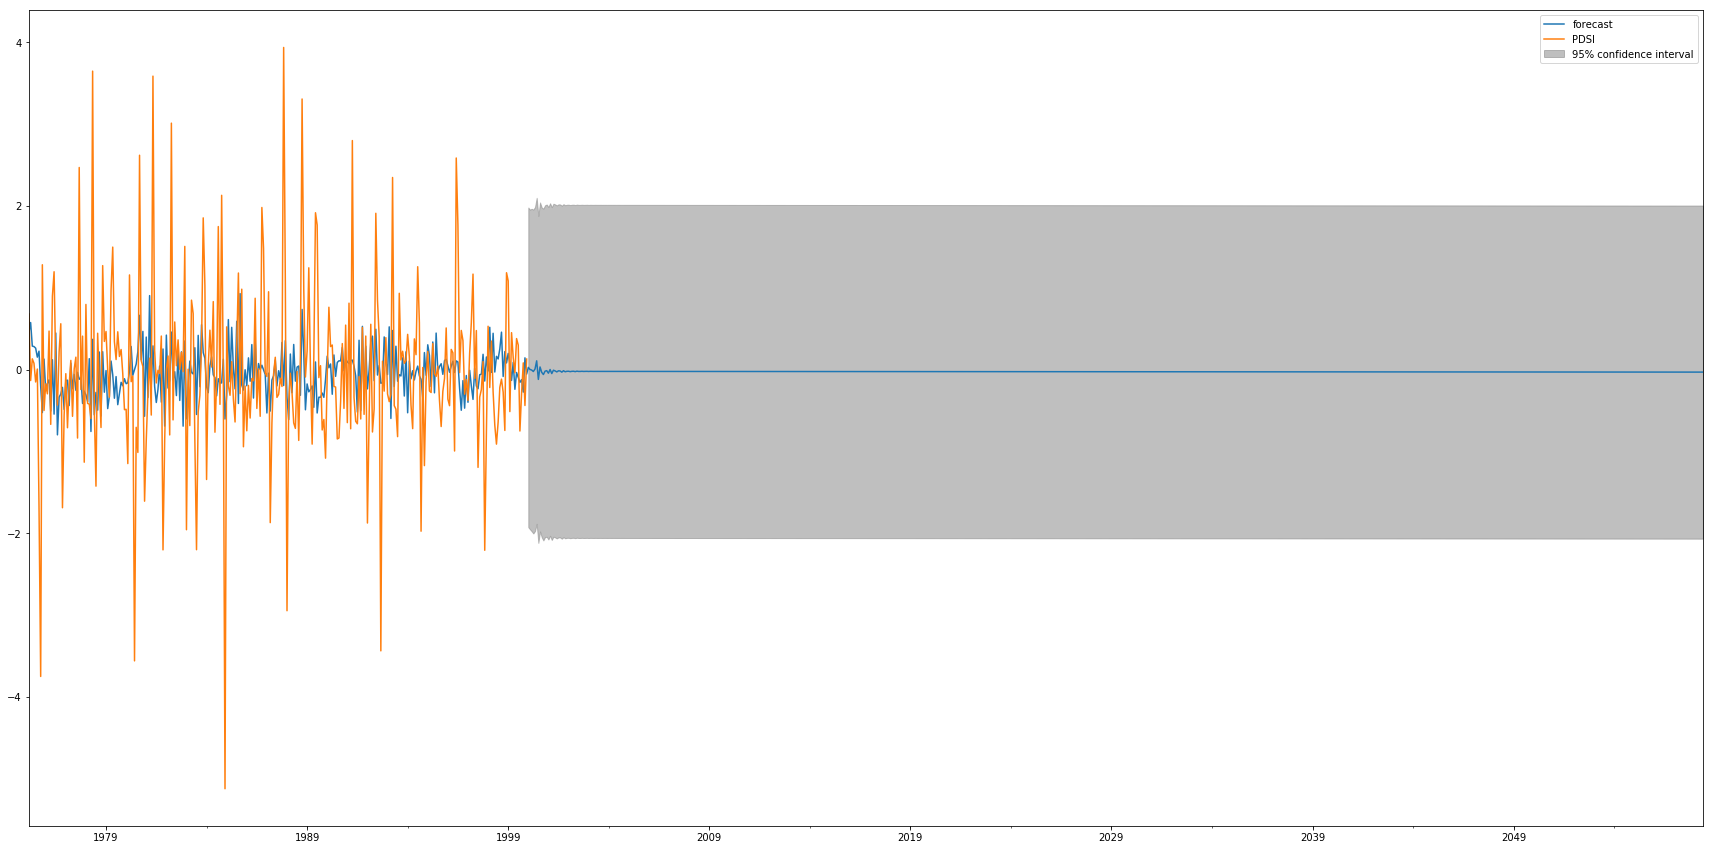

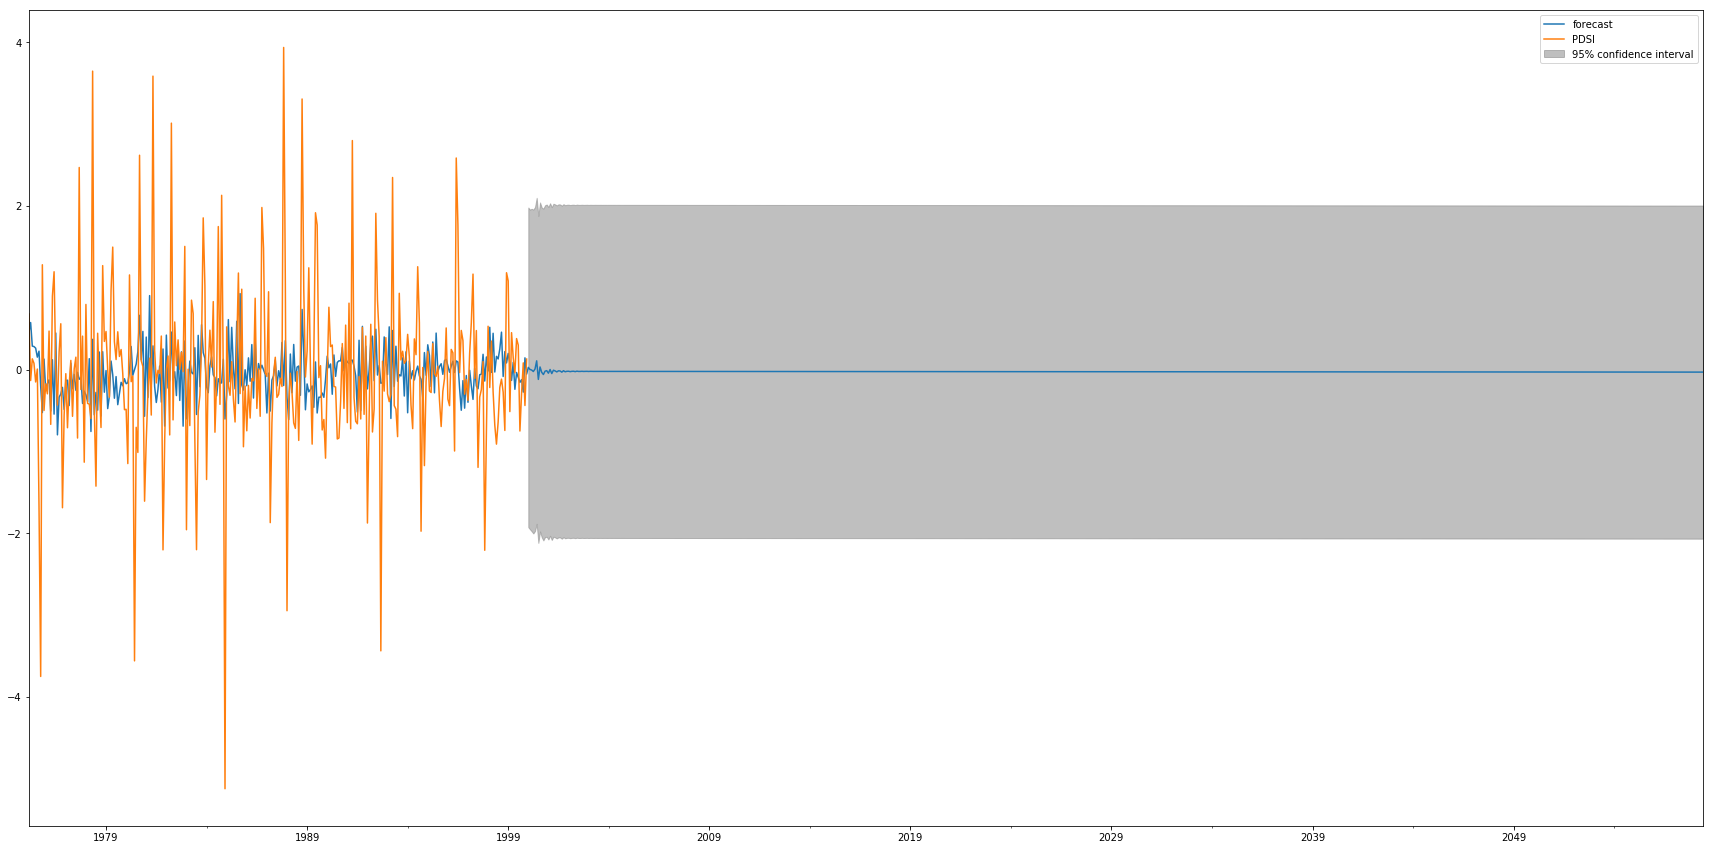

In [34]:
results_ARIMA.plot_predict(1,1000)
#results_ARIMA.forecast(steps=120)

In [40]:
future = results_ARIMA.forecast(steps=131)
print(future[0])

[ 0.0284185   0.00301576 -0.00426313 -0.02206454  0.00816851  0.10821261
 -0.11861503  0.03334906 -0.03213109 -0.05890231 -0.01774523 -0.01174887
 -0.04307749  0.0022169  -0.04720659 -0.00646669 -0.01476739 -0.02706454
 -0.01393213 -0.01555615 -0.03016271 -0.01227303 -0.02516211 -0.01979169
 -0.018809   -0.02364061 -0.0198718  -0.01896439 -0.02348301 -0.01795239
 -0.02124959 -0.02114492 -0.01953375 -0.02124605 -0.02062195 -0.01994623
 -0.02153338 -0.02011783 -0.02073736 -0.02104103 -0.02032071 -0.0208598
 -0.0208449  -0.02047679 -0.02098631 -0.02066338 -0.02071865 -0.02092208
 -0.02069724 -0.0208374  -0.02089633 -0.02075566 -0.0209169  -0.02086672
 -0.02084926 -0.02094236 -0.0208868  -0.02091832 -0.02096329 -0.02092404
 -0.02097595 -0.02098311 -0.02097568 -0.02101686 -0.02101351 -0.02102516
 -0.02105307 -0.02105021 -0.0210716  -0.02108729 -0.02109174 -0.02111336
 -0.02112361 -0.02113413 -0.02115291 -0.02116178 -0.02117613 -0.02119141
 -0.02120157 -0.02121698 -0.02123012 -0.02124195 -0.

In [41]:
dataframe = pd.DataFrame(future[0], columns=['PDSI'])
dataframe

,PDSI
0,0.028419
1,0.003016
2,-0.004263
3,-0.022065
4,0.008169
5,0.108213
6,-0.118615
7,0.033349
8,-0.032131
9,-0.058902


In [42]:
real_data = pd.read_csv('tr.csv')
real_data = real_data.loc[:, ['PDSI']]
real_data 


   


,PDSI
0,-3.366088
1,-3.525975
2,-2.846776
3,-2.229085
4,-1.675951
5,-2.247153
6,-3.350687
7,-3.420927
8,-3.830638
9,-0.766030


In [57]:
rd = ((real_data - dataframe))/real_data
#print(rd)
size = dataframe.shape[0]
mape = (sum(rd['PDSI']))/size
print(mape)
diff = (real_data - dataframe)
rss = sum(diff['PDSI']**2)
print((rss/size)**0.5)
#print((sum(rd**2)/132)**0.5)

0.997546898815
2.11761248079


In [58]:
rd = ((real_data-dataframe))
rd

,PDSI
0,-3.394507
1,-3.528990
2,-2.842512
3,-2.207020
4,-1.684119
5,-2.355366
6,-3.232072
7,-3.454276
8,-3.798507
9,-0.707128


In [63]:
rd['PDSI']

0     -3.394507
1     -3.528990
2     -2.842512
3     -2.207020
4     -1.684119
5     -2.355366
6     -3.232072
7     -3.454276
8     -3.798507
9     -0.707128
10    -0.604289
11    -0.472018
12     0.554737
13    -1.310802
14    -1.043119
15    -0.985656
16    -0.934665
17    -1.450555
18    -0.781620
19    -1.131840
20     1.323919
21     2.075325
22     2.775608
23     3.087240
24     2.210950
25     3.790779
26     0.291422
27     1.291650
28     0.320216
29     0.230902
         ...   
101   -1.967580
102    1.582956
103    2.527739
104    2.620763
105    0.887753
106    1.250027
107    0.462943
108   -0.073981
109    0.702767
110    0.331061
111    2.028658
112    1.595018
113    2.618658
114    2.823664
115    4.074484
116    7.005498
117    1.390609
118    2.538047
119   -0.171133
120   -0.682664
121   -0.920749
122   -1.388664
123   -1.174442
124   -2.039748
125   -2.398105
126   -2.763381
127   -3.454814
128   -3.484418
129   -2.825850
130   -3.430636
Name: PDSI, Length: 131,